## 토픽 모델링 - 20뉴스그룹

토픽 모델링 : 문서 집합에 숨어 있는 주제를 찾아내는 것
* 사람이 수행하는 토픽 모델링 : 더 함축적인 의미로 문장을 요약
* 머신러닝 기반의 토픽 모델 : 숨겨진 주제를 효과적으로 표현할 수 있는 중신 단어를 함축적으로 추출 -> LSA & LDA

fetch_20newsgroups() API는 categories 파라미터를 통해 필요한 주제만 필터링해 추출하고 추출된 텍스트를 Count 기반으로 벡터화 변환

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 8개 주제를 추출
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

#위에서 cats 변수로 기재된 카테고리만 추출. featch_20newsgroups()의 categories에서 cats 입력
news_df = fetch_20newsgroups(subset='all', remove = ('headers', 'footers', 'quotes'),
                             categories= cats, random_state= 0)

#LDA는 Count기반의 벡터화만 적용
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df = 2, stop_words='english', ngram_range=(1,2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


7862개의 문서가 1000개의 피처로 구성된 행렬 데이터
* 토픽의 개수는 위의 뉴스그룹에서 추출한 주제와 동일한 8개로 정함

In [4]:
lda = LatentDirichletAllocation(n_components=8, random_state= 0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

fit을 수행하면 LatentDirichletAllocation객체는 components_ 속성값을 가지게 됨 
* components_는 개별 토픽별로 각 word 피처가 얼마나 많이 그 토픽에 할당됐는지에 대한 수치를 가지고 있음 -> 높은 값일수록 해당 word피처는 그 토픽의 중심 word가 됨

In [5]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

8개의 토픽별로 1000개의 word 피처가 해당 토픽별로 연관도 값을 가지고 있음

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)
        
        #components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes = topic_word_indexes[:no_top_words]
        
        #top_indexes대상인 인덱스별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        
#CountVectorizer객체 내의 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names = count_vect.get_feature_names()

#토픽별로 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


# 문서 군집화

#### 문서 군집화 : 비슷한 텍스트 구성의 문서를 군집화하는 것
* 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류할 수 있으므로 앞에서 소개한 텍스트 분류 기반의 문서 분류와 유사
* 텍스트 분류 기반의 문서 분류 : 지도학습, 문서 군집화 : 비지도학습

#### Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기
* 51개의 텍스트 파일로 구성
* 각 파일은 Tripadvisor(호텔), Edmunds.com(자동차), Amazon.com(전자제품) 사이트에서 가져온 리뷰 문서

In [7]:
import pandas as pd
import glob, os

path = r'C:\Users\seven\OneDrive\바탕 화면\Python Workspace\Kaggle\dataset\OpinosisDataset1.0\topics'
#path로 지정한 디렉터리 밑에 모든 .data 파일의 파일명을 리스트로 취합.
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

#개별 파일의 파일명은 filename_list로 취합,
#개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
    #개별 파일을 읽어서 DataFrame으로 생성
    df = pd.read_table(file_, index_col = None, header = 0, encoding= 'latin1')
    
    #절대 경로로 주어진 파일명을 가공. 리눅스에서 수행할 때는 다음 \\을 /로 변경
    #맨 마지막 .data 확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    
    #파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
#파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df = pd.DataFrame({'filename' : filename_list, 'opinion_text' : opinion_text})
document_df.head()

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...


문서를 TF-IDF 형태로 피처 벡터화

In [8]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1, 2), min_df = 0.05, max_df = 0.85)

#opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\seven\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
from sklearn.cluster import KMeans

#5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=5, max_iter= 10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [11]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,2
1,bathroom_bestwestern_hotel_sfo,...,0
2,battery-life_amazon_kindle,...,1
3,battery-life_ipod_nano_8gb,...,1
4,battery-life_netbook_1005ha,...,1


In [12]:
document_df[document_df['cluster_label'] == 0].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,...,0
32,room_holiday_inn_london,...,0
30,rooms_bestwestern_hotel_sfo,...,0
31,rooms_swissotel_chicago,...,0


In [13]:
document_df[document_df['cluster_label'] == 1].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,...,1
3,battery-life_ipod_nano_8gb,...,1
4,battery-life_netbook_1005ha,...,1
19,keyboard_netbook_1005ha,...,1
26,performance_netbook_1005ha,...,1
41,size_asus_netbook_1005ha,...,1
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,1
44,speed_windows7,...,1


In [14]:
document_df[document_df['cluster_label'] == 2].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,2
5,buttons_amazon_kindle,...,2
8,directions_garmin_nuvi_255W_gps,...,2
9,display_garmin_nuvi_255W_gps,...,2
10,eyesight-issues_amazon_kindle,...,2
11,features_windows7,...,2
12,fonts_amazon_kindle,...,2
23,navigation_amazon_kindle,...,2
33,satellite_garmin_nuvi_255W_gps,...,2
34,screen_garmin_nuvi_255W_gps,...,2


In [15]:
document_df[document_df['cluster_label'] == 3].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
13,food_holiday_inn_london,...,3
14,food_swissotel_chicago,...,3
15,free_bestwestern_hotel_sfo,...,3
20,location_bestwestern_hotel_sfo,...,3
21,location_holiday_inn_london,...,3
24,parking_bestwestern_hotel_sfo,...,3
27,price_amazon_kindle,...,3
28,price_holiday_inn_london,...,3
38,service_bestwestern_hotel_sfo,...,3
39,service_holiday_inn_london,...,3


In [16]:
from sklearn.cluster import KMeans

#3개의 집합으로 군집화
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

#소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by = 'cluster_label')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
48,updates_garmin_nuvi_255W_gps,...,0
44,speed_windows7,...,0
43,speed_garmin_nuvi_255W_gps,...,0
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
41,size_asus_netbook_1005ha,...,0
36,screen_netbook_1005ha,...,0
35,screen_ipod_nano_8gb,...,0
34,screen_garmin_nuvi_255W_gps,...,0
33,satellite_garmin_nuvi_255W_gps,...,0


#### 군집별 핵심 단어 추출하기
각 군집에 속한 문서는 핵심 단어를 주축으로 군집화돼 있을 것 -> 각 군집을 구성하는 핵심 단어가 어떤 것이 있는지 확인

KMeans객체는 각 군집을 구성하는 단어 피처가 군집의 중심을 기준으로 얼마나 가깝게 위치해 있는지 cluster_centers_라는 속성으로 제공
* cluster_centers_는 배열값으로 제공 -> 행은 개별 군집을, 열은 개별 피처를 의미

In [17]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]]


* (3, 4611) -> 3개의 군집, word피처가 4611개로 구성
* 각 행의 배열 값은 각 군집 내의 4611개 피처의 위치가 개별 중심과 얼마나 가까운가를 상대 값으로 나타낸 것 (1이 가까울수록 중심과 가까움)

In [18]:
#군집별 top n 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명을 반환함.
def get_cluster_details(cluster_model, cluster_data, feature_names, cluster_num, top_n_features = 10):
    cluster_details = {}
    
    #cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
    #군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:, ::-1]
    
    #개별 군집벼로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
    for cluster_num in range(cluster_num):
        #개별 군집별 정보를 담을 데이터 초기화
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        #cluster_centers_.argsort()[:, ::-1]로 구한 인덱스를 이용해 top n 피처 단어를 구함.
        top_features_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [feature_names[ind] for ind in top_features_indexes]
        
        #top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함.
        top_features_values = cluster_model.cluster_centers_[cluster_num, top_features_indexes].tolist()
        
        #cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_features_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

In [19]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('###### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :', cluster_detail['filenames'][:7])
        print('====================================')

In [20]:
feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data = document_df,
                                      feature_names=feature_names, cluster_num=3, top_n_features=10)

print_cluster_details(cluster_details)

###### Cluster 0
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'buttons_amazon_kindle', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps']
###### Cluster 1
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_honda_accord_2008', 'interior_toyota_camry_2007', 'mileage_honda_accord_2008', 'performance_honda_accord_2008']
###### Cluster 2
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_hote

* Cluster #0(포터블 전자제품 리뷰) -> 화면과 배터리 수명 등이 핵심 단어, 모바일형이고 엔터테인먼트용 전자제품의 경우 화면 크기와 배터리 수명이 주요 관심사
* Cluster #1(자동차 리뷰) -> 실내 인테리어, 좌석, 연료 효율 등
* Cluster #2(호텔 리뷰) -> 방과 서비스 등이 주요 관심사

### 문서 유사도

문서와 문서 간의 유사도 비교는 코사인 유사도를 사용
* 코사인 유사도 : 벡터와 벡터 간의 유사도를 비교할 때 벡터의 상호 방향성이 얼마나 유사한지에 기반 -> 두 벡터 사이의 사잇각을 구해서 얼마나 유사한지 수치로 적용
* 문서를 피처 벡터화 변환하면 차원이 매우 많은 희소 행렬이 됨 -> 벡터 간 크기에 기반한 유사도 지표는 정확도가 떨어짐 
* 문서가 매우 긴 경우 단어의 빈도수도 더 많을 것이기 때문에 이러한 빈도수에만 기반해서는 공정한 비교를 할 수 없음

In [21]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2))))
    similarity = dot_product/l2_norm
    
    return similarity

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [23]:
#TfidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환.
feature_vect_dense = feature_vect_simple.todense()

#첫 번째 문장과 두 번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

#첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [24]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[1]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect3)
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect2, vect3)
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.402
문장 2, 문장 3 Cosine 유사도: 0.456


In [25]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


cos_similarity()는 쌍으로(pair) 코사인 유사도 값을 제공, Ex) 1번째 문서와 2,3번째 문서의 코사인 유사도/ 2번째 문서와 1,3번째 문서의 코사인 유사도

In [26]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


#### Opinion Review 데이터 세트를 이용한 문서 유사도 측정

In [27]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'C:\Users\seven\OneDrive\바탕 화면\Python Workspace\Kaggle\dataset\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_, index_col = None, header = 0, encoding='latin1')
    filename_ = file_.split('\\')[1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
document_df = pd.DataFrame({'filename' : filename_list, 'opinion_text' : opinion_text})
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1, 2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\seven\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

#cluster_label = 1인 데이터는 호텔로 군집화된 데이터임. DataFrame에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label'] == 1].index
print('호텔로 군집화 된 문서들의 DataFrame Index:', hotel_indexes)

#호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('#### 비교 기준 문서명 ', comparison_docname, ' 와 타 문서 유사도 ####')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출, 이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 DataFrame Index: Int64Index([6, 7, 16, 17, 18, 22, 25, 29, 37, 47], dtype='int64')
#### 비교 기준 문서명  Users  와 타 문서 유사도 ####
[[1.         0.83969704 0.15655631 0.33044002 0.25981841 0.16544257
  0.27569738 0.18050974 0.65502034 0.06229873]]


Text(0.5, 1.0, 'Users')

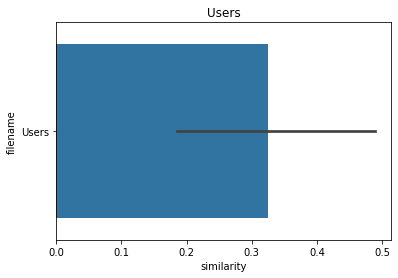

In [29]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#첫 번재 문서와 타 문서 간 유사도가 큰순으로 정렬한 인덱스를 추출하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]

#유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

#유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

#유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x = 'similarity', y = 'filename', data = hotel_1_sim_df)
plt.title(comparison_docname)

In [30]:
hotel_1_sim_value

array([0.83969704, 0.65502034, 0.33044002, 0.27569738, 0.25981841,
       0.18050974, 0.16544257, 0.15655631, 0.06229873])

### 한글 텍스트 처리 - 네이버 영화 평점 감성 분석

#### 한글 NLP 처리의 어려움
* 띄어쓰기와 다양한 조사 때문에 어려움

#### KoNLPy
KoNLPy : 파이썬의 대표적인 한글 형태소 패키지
* 형태소 : 단어로서 의미를 가지는 최소 단위
* 형태소 분석 : 말뭉치를 이러한 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업

In [31]:
import pandas as pd

train_df = pd.read_csv('C:/Users/seven/OneDrive/바탕 화면/Python Workspace/Kaggle/dataset/네이버 영화 평점/ratings_train.txt', sep = '\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [32]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

* 0과 1의 비율이 어느 한쪽으로 치우치치 않고 균등한 분포를 나타냄
* 'document'칼럼에 Null이 일부 존재하므로 이 값은 공백으로 변환
* 문자가 아닌 숫자의 경우 단어적인 의미로 부족하므로 파이썬의 정규 표현식 모듈이 re를 이용해 이 역시 공백으로 변환

In [33]:
import re

train_df = train_df.fillna(' ')
#정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 /d는 숫자를 의미함)
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r'/d+', ' ', x))

#테스트 데이터 세트를 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('C:/Users/seven/OneDrive/바탕 화면/Python Workspace/Kaggle/dataset/네이버 영화 평점/ratings_test.txt', sep = '\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

#id 칼럼 삭제
train_df.drop('id', axis = 1, inplace= True)
test_df.drop('id', axis = 1, inplace= True)

TF-IDF 방식으로 단어를 벡터화
* 각 문장을 한글 형태소 분석을 통해 형태소 단어로 토큰화
* 한글 형태소 엔진은 SNS 분석에 적합한 Twitter 클래스를 이용

In [34]:
conda install -c conda-forge jpype1

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [36]:
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    #입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko

C:\Users\seven\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#Twitter 객체의 morphs()객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1, 2), min_df = 3, max_df = 0.9)
tfidf_vect.fit(train_df['document'])
tdidf_matrix_train = tfidf_vect.transform(train_df['document'])

KeyboardInterrupt: 

In [ ]:
#로지스틱 회귀를 이용해 감성 분석 분류 수행
lg_clf = LogisticRegression(random_state=0)

#파라미터 C 최적화를 위해 GridSearchCV를 이용
params = {'C' : [1, 3.5, 4.5, 5.5, 10]}
grid_cv = GridSearchCV(lg_clf, param_grid=params, cv = 3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

In [ ]:
from sklearn.metrics import accuracy_score

#학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환함
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

#classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ', accuracy_score(test_df['label'], preds)

### 캐글 Mercari Price Suggestion Challenge
Mercari Price Suggestion Challenge : 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제

* train_id : 데이터 id
* name : 제품명
* item_condition_id : 판매자가 제공하는 제품 상태
* category_name : 카테고리 명
* brand_name : 브랜드 이름
* price : 제품 가격, 예측을 위한 타깃 속성
* shipping : 배송비 무료 여부, 1이면 무료(판매자가 지불), 0이면 유로(구매자 지불)
* item_description : 제품에 대한 설명
기존 회귀 예제와 다른 점은 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점 

#### 데이터 전처리

In [3]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('C:/Users/seven/OneDrive/바탕 화면/Python Workspace/Kaggle/dataset/Mercari/mercari_train.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [4]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


brand_name : 매우 많은 Null값을 가지고 있음, 가격에 영향을 미치는 중요 요인으로 판단됨 -> 적절한 문자열로 치환

회귀에서 Target값의 정규 분포도는 매우 중요 -> 왜곡돼 있을 경우 보통 로그를 씌워서 변환하면 대부분 정규 분포의 형태를 가지게 됨

C:\Users\seven\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

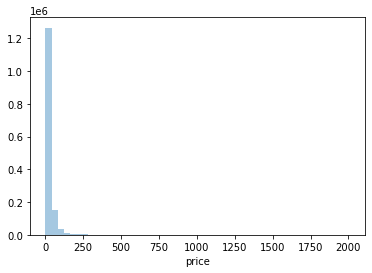

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize = (6, 4))
sns.distplot(y_train_df, kde = False)

C:\Users\seven\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

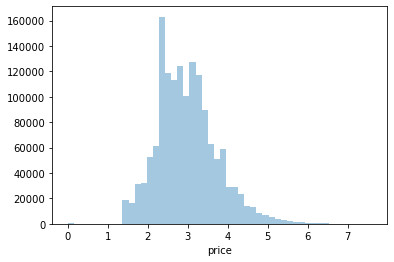

In [8]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde = False)

In [9]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [10]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


* Shipping 칼럼은 배송비 유무 -> 값이 비교적 균이 
* Item_condition_id는 판매자가 제공하는 제품 상태 -> 각 값이 의미하는 바는 캐글에 기재돼 있지 않음

item_description 칼럼은 Null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet'값으로 돼 있음

In [11]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음, 피처 추출시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수도 있지만 여기서는 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습
* 대, 중, 소 칼럼은 mercari_df에서 cat_dae, cat_jung, cat_so로 부여
* apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 cat_dae, cat_jung, cat_so의 DataFrame 칼럼으로 분리해야함 -> zip과 *를 apply lambda 식에 적용

In [12]:
#apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']
    
#위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


brand_name, category_name, item_description 칼럼의 Null값은 일괄적으로 'Other Null'로 동일하게 변경
* brand_name은 price 값 결정에 영향을 많이 줄 것으로 판단 -> 이 Null값을 다른 값으로 변경하는 것은 적절하지 않을 것으로 판단되므로 일괄적으로 'Other_Null'로 변경

In [16]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value= 'Other Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other Null')

#각 컬럼별로 Null 값 건수 확인. 모두 0이 나와야 함 
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

#### 피처 인코딩과 피처 벡터화

문자열 컬럼 -> 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별
* 예측 모델은 price값, 즉 상품 가격을 예측해야 하므로 회귀 모델을 기반으로 함, 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정
* 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용
* 피처 벡터화의 경우 비교적 짧은 텍스트의 경우는 Count기반의 벡터화, 긴 텍스트는 TF-IDF 기반의 벡터화 적용

In [19]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


brand_name의 경우 대부분 명료한 문자열로 돼 있음 -> 별도의 피처 벡터화 형태로 만들 필요없이 인코딩 변환을 적용

In [21]:
print('name 의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

name 의 종류 개수 : 1225273
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


상품명은 name 속성의 경우 종류가 매우 많음 -> 전체 데이터가 1482535개이므로 개별적으로 거의 고유한 상품명을 가지고 있음
* Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반으로 피처 벡터화 변환을 적용
* cat_dae, cat_jung, cat_so 칼럼도 원-핫 인코딩을 적용
* shipping, item_condition_id는 모두 원-핫 인코딩 적용
* item_description은 상품에 대한 간단 설명으로 데이터 세트에서 가장 긴 텍스트를 가지고 있음 -> TF-IDF 변환

In [23]:
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_desription 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_desription 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [24]:
#name 속성에 대한 피처 벡터화 변환
cnt_vect = CountVectorizer()
X_name = cnt_vect.fit_transform(mercari_df.name)

#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬
* X_name, X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 함
* 나머지 칼럼들의 인코딩도 모두 X_name, X_descp와 결합돼 ML모델을 실행하는 기반 데이터 세트로 재구성돼야함 -> 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용 후 함께 결합
* 사이킷런의 LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원

In [25]:
from sklearn.preprocessing import LabelBinarizer

#brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

#cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [26]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape: {1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape: (1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합

In [27]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


88

#### 릿지 회귀 모델 구축 및 평가
* 여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행 -> 필요한 로직 함수화
* 모델을 평가하는 평가로직을 함수화 (평가 지표 : RMSLE(오류 값에 로그를 취해 RMSE를 구하는 방식)) why? 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 

In [28]:
def rmsle(y, y_pred):
    #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y)- np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    
    #원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result